# Question Answering Model

### SQuAD Dataset


Download the dataset from [here](https://rajpurkar.github.io/SQuAD-explorer/)

In [ ]:
# train-squad
# project_path = "/kaggle/input/train-squad/"

# # development
project_path = ""
# dataset_file_name = "dev-v2.0.json"
dataset_file_name = "train-v2.0.json"

In [3]:
# Importing packages
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# % matplotlib inline

from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Average
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation,RepeatVector
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import History
import nltk
# nltk.download("punkt")

2025-04-22 20:55:43.203394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745355343.409207      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745355343.468499      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1. Getting Data


In [4]:
with open(project_path+dataset_file_name,mode="rt",encoding="utf-8") as file:
    dataset = json.load(file)

## 2. Pre-processing

In [5]:
import nltk
real_max_target_seq_length = 0
ans_total_seq_length = 0
total_ans = 0
ans_having_three_tokens = 0

# extract paragraphs,question and answers from SQuAD Da
def get_context_question_answer_tuples_from_SQuAD_dataset(dataset,max_data_count, max_context_sequence_length):
    data = list()
    global real_max_target_seq_length
    global ans_total_seq_length
    global total_ans
    global ans_having_three_tokens
    for instance in dataset['data']:
        for paragraph in instance['paragraphs']:
            context = paragraph['context']
            
            tokenized_context = [word.lower() for word in nltk.word_tokenize(context)]
            if(len(tokenized_context) > max_context_sequence_length):
                continue
                
            qas = paragraph['qas']
            for question_answers_tuple in qas:
                question = question_answers_tuple['question']
                answers = question_answers_tuple['answers']
                total_ans+=len(answers)
                if(len(answers) > 0):
                    answer = answers[0]
                # for answer in answers:
                    ans = answer['text']
                    tokenized_answer = [w.lower() for w in nltk.word_tokenize(ans)]
                    
                    # some stats
                    real_max_target_seq_length = max(len(tokenized_answer),real_max_target_seq_length)
                    ans_total_seq_length+=len(answer)
                    if(len(tokenized_answer) <=3):
                        ans_having_three_tokens+=1
                        
                    if len(data) < max_data_count:
                        data.append((context, question, ans))

            if len(data) >= max_data_count:
                break

    return data

In [83]:
max_data_count = 5000

# init globals
real_max_target_seq_length = 0
ans_total_seq_length = 0
total_ans = 0
ans_having_three_tokens= 0

max_question_sequence_length = 60
max_context_sequence_length = 500
max_answer_sequence_length = 46

max_encoder_len = max_question_sequence_length + max_context_sequence_length
max_decoder_len = max_answer_sequence_length

embedding_dim = 200
lstm_units = 64
 # no computation resources to increase units 
contexts=[]
questions=[]
answers=[]

data = get_context_question_answer_tuples_from_SQuAD_dataset(dataset,max_data_count,max_context_sequence_length)
print("Total Q&A data size",len(data))

for (context, question, answer) in data:
    questions.append(question)
    contexts.append(context)
    answers.append(answer)
    
print(f"{ans_total_seq_length/total_ans} is the average number of words per answer")
print(f"{((ans_having_three_tokens/total_ans)*100)}% answers having three words or less")
print(f"{real_max_target_seq_length} is the maxiumum number of words per answer")

Total Q&A data size 5000
0.6035716433166978 is the average number of words per answer
21.736516144549338% answers having three words or less
37 is the maxiumum number of words per answer


## Tokenizer

In [84]:
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(questions + contexts + answers)
vocab_size = len(tokenizer.word_index) + 1

if 'startseq' not in tokenizer.word_index:
    tokenizer.word_index['startseq'] = vocab_size
    vocab_size += 1
if 'endseq' not in tokenizer.word_index:
    tokenizer.word_index['endseq'] = vocab_size
    vocab_size += 1
    
def preprocess(texts, max_len):
    seq = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=max_len, padding='post')


# SeqtoSeq Model Creation

## Encoder
* Sequence Generation
* Model Creation
* Visualization

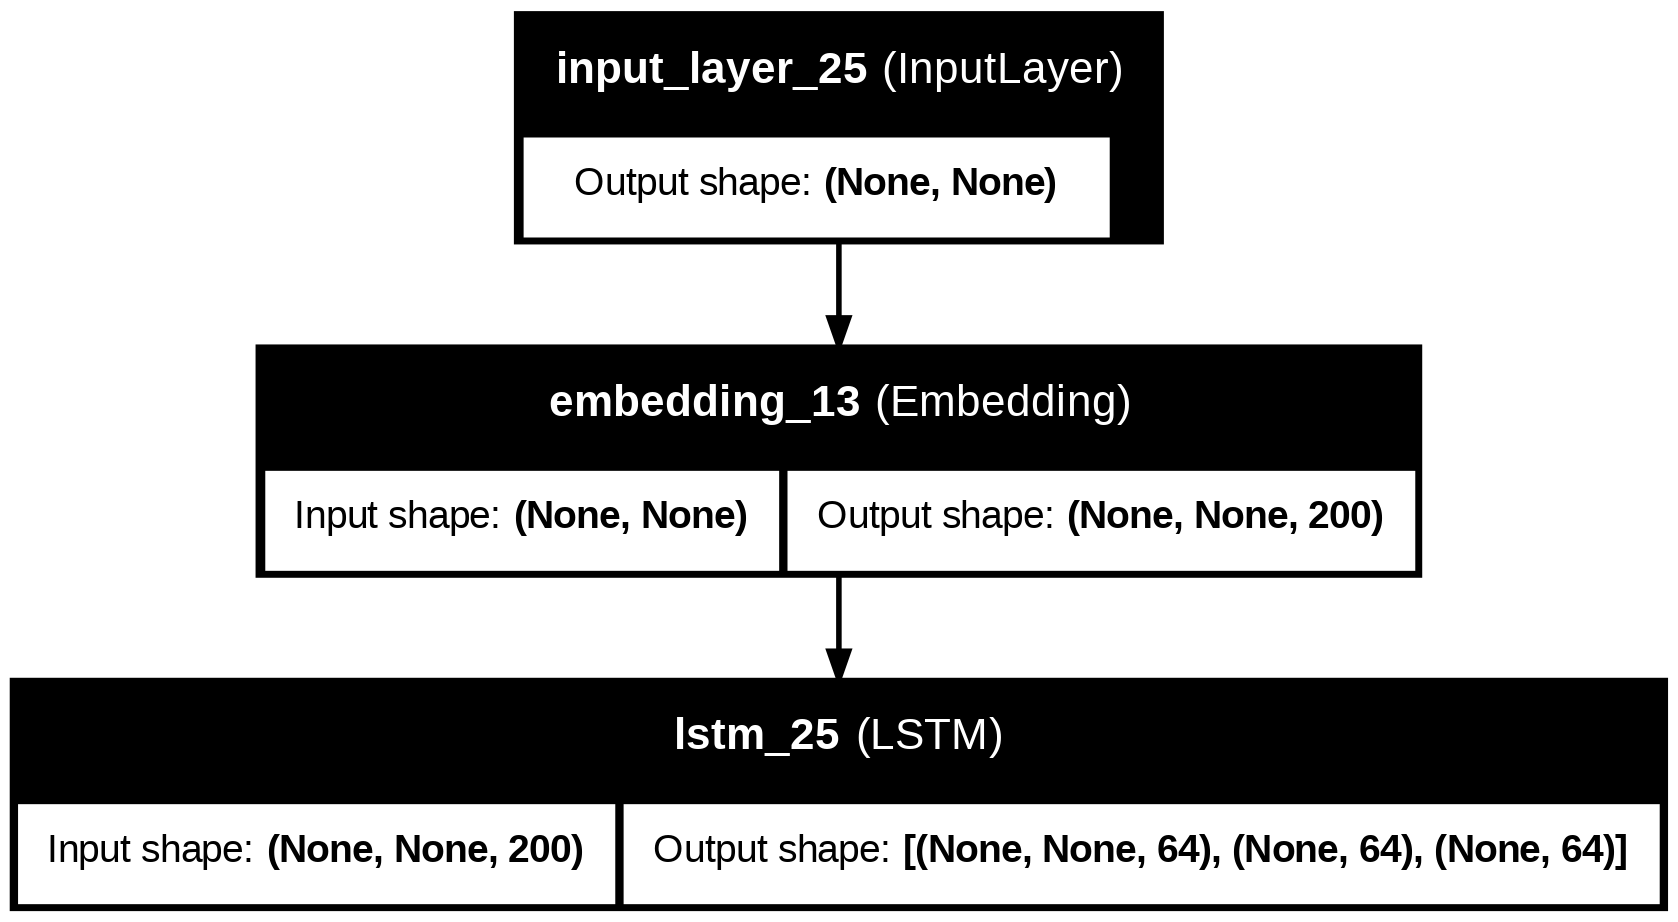

In [85]:
# Sequence Generation
encoder_input_data = preprocess(
    [f"question: {q} context: {c}" for q,c in zip(questions, contexts)],
    max_encoder_len
)

# Model Creation
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(vocab_size, embedding_dim)(encoder_inputs)
# encoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
encoder_lstm = LSTM(
    units=lstm_units,  
    activation='tanh', 
    recurrent_activation='sigmoid',
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    # dropout=0.03, no computation resources to test 
    # recurrent_dropout=0.02, no computation resources to test 
    return_sequences=True,
    return_state=True
)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Visualization
from tensorflow.keras.utils import plot_model
encoder_model_viz = Model(encoder_inputs, [encoder_outputs] + encoder_states, name='Encoder_Model')

plot_model(encoder_model_viz, show_shapes=True, show_layer_names=True, to_file='encoder_model.png')

## Decoder
* Sequence Generation
* Model Creation

In [86]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

decoder_input_data = preprocess(
    [f"startseq {a}" for a in answers],
    max_decoder_len
)

decoder_target_data = preprocess(
    [f"{a} endseq" for a in answers],
    max_decoder_len
)

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(vocab_size, embedding_dim, name="decoder_embedding")(decoder_inputs)
# decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_lstm = LSTM(
    units=lstm_units,
    activation='tanh',
    recurrent_activation='sigmoid',
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    # dropout=0.03,
    # recurrent_dropout=0.02,
    return_sequences=True,
    return_state=True
)
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_states = [state_h, state_c]

# Visualization
decoder_model_vis = Model([decoder_inputs] + encoder_states, [decoder_outputs] + decoder_states)
plot_model(decoder_model_vis, to_file='decoder_model.png', show_shapes=True, show_layer_names=True)

# Output
decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_dense')
decoder_outputs_final = decoder_dense(decoder_outputs)




In [87]:

# 5. Full Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)

model.compile(optimizer="adam", loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

# Train Model

In [ ]:
# 6. Train
training_results = model.fit(
    [encoder_input_data, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),
    batch_size=30,
    epochs=100,
    verbose=1
)

Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - loss: 5.8283 - sparse_categorical_accuracy: 0.8801
Epoch 2/100
 75/167 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.7308 - sparse_categorical_accuracy: 0.9107

## Inference Model

In [ ]:
# 7. Inference Setup

# Encoder inference model
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder inference model
decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_inf = Input(shape=(1,))
dec_emb_inf = model.get_layer("decoder_embedding")(decoder_inputs_inf)

decoder_outputs, state_h, state_c = decoder_lstm(
    dec_emb_inf, initial_state=[decoder_state_input_h, decoder_state_input_c]
)
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_inf, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs, state_h, state_c]
)


# Generator 

In [50]:

# 8. Generate Answers
def generate_answer(question, context):
    # Encode input
    input_seq = preprocess([f"question: {question} context: {context}"], max_encoder_len)
    
    # Get encoder states and outputs
    enc_h, enc_c = encoder_model.predict(input_seq)
    
    # Start with start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['startseq']
    
    # Generate tokens
    answer = []
    for _ in range(max_decoder_len):
        output_tokens, h, c = decoder_model.predict(
            [target_seq, enc_h, enc_c])
        
        # Get next word
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer.index_word.get(sampled_token_index, '')
        
        if sampled_word == 'endseq':
            break
            
        answer.append(sampled_word)
        
        # Update for next step
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        enc_h, enc_c = h, c
    
    return ' '.join(answer)

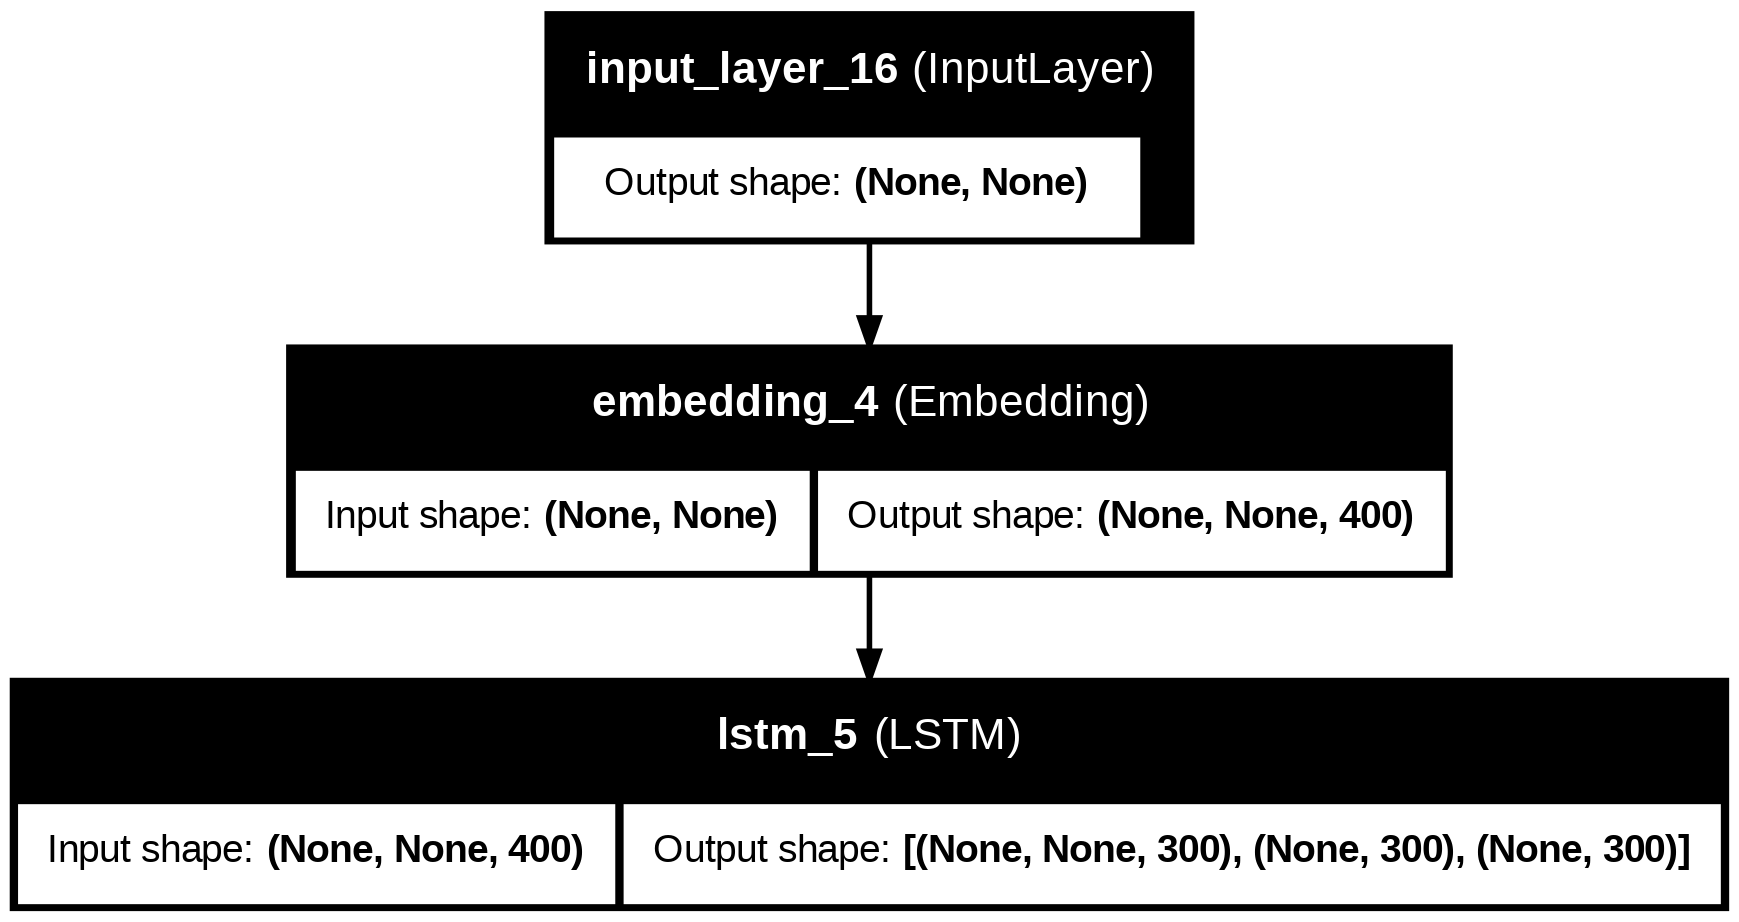

In [51]:
from tensorflow.keras.utils import plot_model
encoder_model_viz = Model(encoder_inputs, [encoder_outputs] + encoder_states, name='Encoder_Model')

plot_model(encoder_model_viz, show_shapes=True, show_layer_names=True, to_file='encoder_model.png')


# Testing

In [52]:
# 9. Test
nTest = 10
for q, c in zip(questions, contexts):
    print(f"Q: {q}\nC: {c}\nA: {generate_answer(q, c)}\n")
    if(nTest == 0):
        break
    nTest-=1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [ ]:

# 9. Test
nTest = 10
for q, c in zip(questions, contexts):
    print(f"Q: {q}\nC: {c}\nA: {generate_answer(q, c)}\n")
    if(nTest == 0):
        break
    nTest-=1

# 📉 Metrics

## - *Loss* 

## - *Sparse Categorical Accuracy*

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(training_results.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


plt.plot(training_results.history['sparse_categorical_accuracy'])
plt.title('Token-Level Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

